In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **Data Classification**

## **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## **Reading Train Data**

In [3]:
Titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
Titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
Titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
Titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
Titanic_train.shape

(891, 12)

## **Nulls at Train data**

To extract if data hase any nulls:

In [8]:
Titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We fill Nulls at **age** column by using median:

In [9]:
Titanic_train['Age'].fillna(Titanic_train['Age'].median(), inplace=True)

We fill Nulls at ***Embarked*** by using mode:

In [10]:
Titanic_train['Embarked'].fillna(Titanic_train['Embarked'].mode()[0], inplace=True)

We extract another column from **Cabin** column to fill nulls by using this code:

In [11]:
Titanic_train['HasCabin'] = Titanic_train['Cabin'].notnull().astype(int)

## **Outliers**

To visualization Outliers by using BoxPlot:

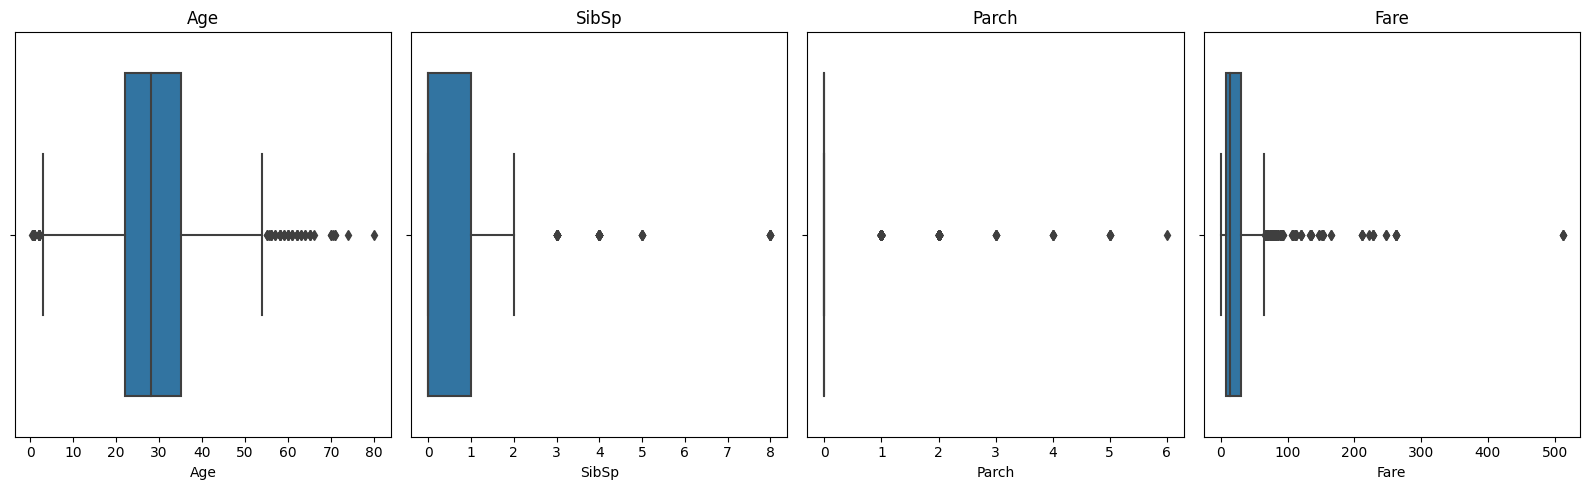

In [12]:
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']

# boxplots
plt.figure(figsize=(16, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(x=Titanic_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

To calculate Percentage of Outliers we use this code:

In [13]:
def outlier_percentage(Titanic_train):
    numeric_cols = Titanic_train.select_dtypes(include=['int64', 'float64']).columns
    results = []

    for col in numeric_cols:
        Q1 = Titanic_train[col].quantile(0.25)
        Q3 = Titanic_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Outliers
        outliers = Titanic_train[(Titanic_train[col] < lower) | (Titanic_train[col] > upper)][col].count()
        total = Titanic_train[col].notnull().sum()
        percent = (outliers / total) * 100
        
        results.append({
            'Column': col,
            'num of Outliers':outliers,
            'Total': total,
            'Percentage of Outliers (%)': round(percent, 2)})
    
    return pd.DataFrame(results)


outlier_df = outlier_percentage(Titanic_train)
print(outlier_df)

        Column  num of Outliers  Total  Percentage of Outliers (%)
0  PassengerId                0    891                        0.00
1     Survived                0    891                        0.00
2       Pclass                0    891                        0.00
3          Age               66    891                        7.41
4        SibSp               46    891                        5.16
5        Parch              213    891                       23.91
6         Fare              116    891                       13.02
7     HasCabin              204    891                       22.90


## **Feature Extraction**

To extract Title from name feature we use this code:

In [14]:
Titanic_train['Title'] = Titanic_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# to drop main column
Titanic_train.drop('Name', axis=1, inplace=True)

We extract FamilySize from Feature we use this code :

In [15]:
Titanic_train['FamilySize'] = Titanic_train['SibSp'] + Titanic_train['Parch'] + 1

To make feature called IsAlone by using thos code:

In [16]:
Titanic_train['IsAlone'] = (Titanic_train['FamilySize'] == 1).astype(int)

We extract feature from Cabin depend on first letter from cabin :

In [17]:
Titanic_train['Deck'] = Titanic_train['Cabin'].str[0]
Titanic_train['Deck'] = Titanic_train['Deck'].fillna('U')  # U = Unknown

We extract TicketPrefix Feature:

In [18]:
Titanic_train['TicketPrefix'] = Titanic_train['Ticket'].apply(lambda x: x.split(' ')[0] if not x.isdigit() else 'None')

We extract FarePerPerson for one person:

In [19]:
Titanic_train['FarePerPerson'] = Titanic_train['Fare'] / Titanic_train['FamilySize']

We classified age by using this code:

In [20]:
Titanic_train['AgeGroup'] = pd.cut(Titanic_train['Age'], bins=[0,12,18,35,60,80], labels=['Child','Teen','Adult','MiddleAge','Senior'])

In [21]:
Titanic_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title,FamilySize,IsAlone,Deck,TicketPrefix,FarePerPerson,AgeGroup
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,2,0,U,A/5,3.62500,Adult
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,0,C,PC,35.64165,MiddleAge
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,1,1,U,STON/O2.,7.92500,Adult
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,2,0,C,None,26.55000,Adult
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,1,1,U,None,8.05000,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,211536,13.0000,NaN,S,0,Rev,1,1,U,None,13.00000,Adult
887,888,1,1,female,19.0,0,0,112053,30.0000,B42,S,1,Miss,1,1,B,None,30.00000,Adult
888,889,0,3,female,28.0,1,2,W./C. 6607,23.4500,NaN,S,0,Miss,4,0,U,W./C.,5.86250,Adult
889,890,1,1,male,26.0,0,0,111369,30.0000,C148,C,1,Mr,1,1,C,None,30.00000,Adult


We make **Scaling** for numerical column:

In [22]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson']

# to fill nulls by median
Titanic_train[numeric_cols] = Titanic_train[numeric_cols].fillna(Titanic_train[numeric_cols].median())

# Scaling
scaler = StandardScaler()
Titanic_train[numeric_cols] = scaler.fit_transform(Titanic_train[numeric_cols])

We make **Encoding** for categorical columns:

In [23]:
# Define the categorical columns
categorical_cols = ['Sex', 'Embarked', 'Title', 'Deck', 'AgeGroup', 'TicketPrefix']

# Convert columns to 'object' type to avoid Categorical errors
Titanic_train[categorical_cols] = Titanic_train[categorical_cols].astype('object')

# Fill missing values with 'Unknown'
Titanic_train[categorical_cols] = Titanic_train[categorical_cols].fillna('Unknown')

# Apply One-Hot Encoding (drop_first=True to avoid dummy variable trap)
Titanic_train = pd.get_dummies(Titanic_train, columns=categorical_cols, drop_first=True)

We drop non numerical columns:

In [24]:
drop_cols = ['Name', 'Ticket', 'Cabin','PassengerId']  # columns with raw strings
Titanic_train = Titanic_train.drop(columns=drop_cols, errors='ignore')

In [25]:
Titanic_train.shape

(891, 84)

In [26]:
Titanic_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,FamilySize,IsAlone,FarePerPerson,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
0,0,3,-0.565736,0.432793,-0.473674,-0.502445,0,0.059160,0,-0.454798,...,False,False,False,False,False,False,False,False,False,False
1,1,1,0.663861,0.432793,-0.473674,0.786845,1,0.059160,0,0.438994,...,False,False,False,False,False,False,False,False,False,False
2,1,3,-0.258337,-0.474545,-0.473674,-0.488854,0,-0.560975,1,-0.334757,...,False,False,False,False,True,False,False,False,False,False
3,1,1,0.433312,0.432793,-0.473674,0.420730,1,0.059160,0,0.185187,...,False,False,False,False,False,False,False,False,False,False
4,0,3,0.433312,-0.474545,-0.473674,-0.486337,0,-0.560975,1,-0.331267,...,False,False,False,False,False,False,False,False,False,False


## **Splitting Data**

In [27]:
X = Titanic_train.drop('Survived', axis=1)
y = Titanic_train['Survived']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Modeling**

We use **RandomForest Model** after make **GridSearch** with best parameters:

In [29]:
# Best params after GridSearchCV
best_rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42)

# Training
best_rf_model.fit(X_train, y_train)

# Prediction on test data
y_pred_rf = best_rf_model.predict(X_test)

#### **Evaluation of RandomForest Model**

In [30]:
# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Final Random Forest Accuracy: {acc_rf:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred_rf))

Final Random Forest Accuracy: 0.8324

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Visualizatio **confusion Metrix** :

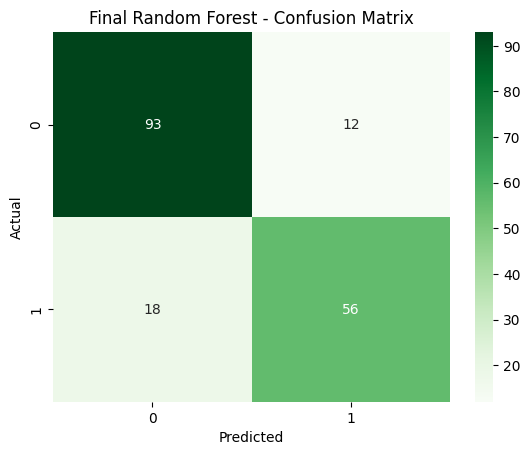

In [31]:
# Confusion metrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Final Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


We use **CatBoostClassiier Model** after make **GridSearch** with best parameters:

In [32]:
# Best model after GridSearch
best_cat_model = CatBoostClassifier(
    depth=6,
    iterations=600,
    l2_leaf_reg=1,
    learning_rate=0.01,
    verbose=0,
    random_state=42
)

# Training data
best_cat_model.fit(X_train, y_train)

# Prediction on test data
y_pred = best_cat_model.predict(X_test)

#### **Evaluation of CatBoostClassifier Model**

In [33]:
# Evaluation
acc = accuracy_score(y_test, y_pred)
print(f" Final CatBoost Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

 Final CatBoost Accuracy: 0.8324

 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       105
           1       0.83      0.74      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Visualizatio **confusion Metrix :**

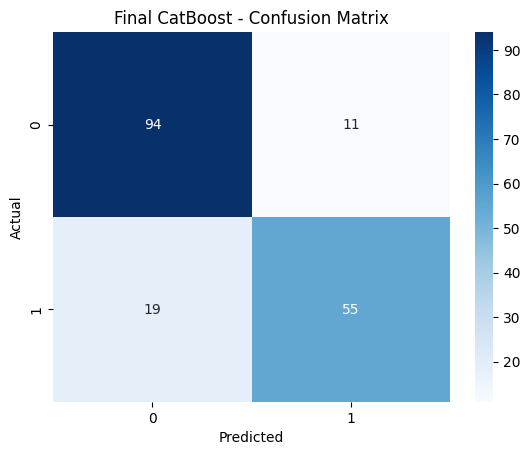

In [34]:
# Confussion Metrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Final CatBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

To compare between two models by visualization by **ROC Curve** we use this code:

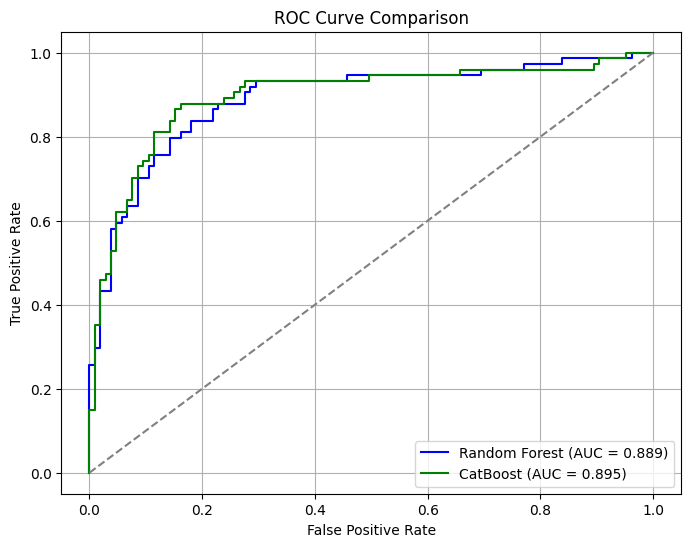

In [35]:
# Probabilities for Random Forest
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# Probabilities for CatBoost
y_proba_cat = best_cat_model.predict_proba(X_test)[:, 1]
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
auc_cat = roc_auc_score(y_test, y_proba_cat)

# Plot both ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='blue')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_cat:.3f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

So we use CatBoost Model beacuse it make model more stable for prediction

### **Reading Test data**

In [36]:
Titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [37]:
Titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [38]:
Titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [39]:
Titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [40]:
Titanic_test.shape

(418, 11)

### **Nulls at Test data**

To extract if data hase any nulls:

In [41]:
Titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We fill Nulls at **age** column by using median:

In [42]:
Titanic_test['Age'].fillna(Titanic_test['Age'].median(), inplace=True)

We fill Nulls at **Embarked** by using mode:

In [43]:
Titanic_test['Embarked'].fillna(Titanic_test['Embarked'].mode()[0], inplace=True)

We extract another column from **Cabin** column to fill nulls by using this code:

In [44]:
Titanic_test['HasCabin'] = Titanic_test['Cabin'].notnull().astype(int)

### **Feature Extraction at Test data**

To extract Title from **name** feature we use this code:

In [45]:
Titanic_test['Title'] = Titanic_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# to drop main column
Titanic_test.drop('Name', axis=1, inplace=True)

We extract FamilySize from Feature we use this code :

In [46]:
Titanic_test['FamilySize'] = Titanic_test['SibSp'] + Titanic_test['Parch'] + 1

To make feature called IsAlone by using thos code:

In [47]:
Titanic_test['IsAlone'] = (Titanic_test['FamilySize'] == 1).astype(int)

We extract feature from Cabin depend on first letter from cabin :

In [48]:
Titanic_test['Deck'] = Titanic_test['Cabin'].str[0]
Titanic_test['Deck'] = Titanic_test['Deck'].fillna('U')  # U = Unknown

We extract TicketPrefix Feature:

In [49]:
Titanic_test['TicketPrefix'] = Titanic_test['Ticket'].apply(lambda x: x.split(' ')[0] if not x.isdigit() else 'None')

We extract FarePerPerson for one person:

In [50]:
Titanic_test['FarePerPerson'] = Titanic_test['Fare'] / Titanic_test['FamilySize']

We classified age by using this code:

In [51]:
Titanic_test['AgeGroup'] = pd.cut(Titanic_test['Age'], bins=[0,12,18,35,60,80], labels=['Child','Teen','Adult','MiddleAge','Senior'])

We make **Scaling** for numerical column:

In [52]:
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson']

# to fill nulls by median
Titanic_test[numeric_cols] = Titanic_test[numeric_cols].fillna(Titanic_test[numeric_cols].median())

# Scaling
scaler = StandardScaler()
Titanic_test[numeric_cols] = scaler.fit_transform(Titanic_test[numeric_cols])

We make **Encoding** for categorical columns:

In [53]:
# Define the categorical columns
categorical_cols = ['Sex', 'Embarked', 'Title', 'Deck', 'AgeGroup', 'TicketPrefix']

# Convert columns to 'object' type to avoid Categorical errors
Titanic_test[categorical_cols] = Titanic_test[categorical_cols].astype('object')

# Fill missing values with 'Unknown'
Titanic_test[categorical_cols] = Titanic_test[categorical_cols].fillna('Unknown')

# Apply One-Hot Encoding (drop_first=True to avoid dummy variable trap)
Titanic_test = pd.get_dummies(Titanic_test, columns=categorical_cols, drop_first=True)

We drop non numerical columns:

In [54]:
Test_id = Titanic_test['PassengerId'].copy()

In [55]:
drop_cols = ['Name', 'Ticket', 'Cabin','PassengerId']  # columns with raw strings
Titanic_test = Titanic_test.drop(columns=drop_cols, errors='ignore')

In [56]:
Titanic_test.shape

(418, 65)

In [57]:
X_test = Titanic_test.copy()

# add loss columns
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# rearrange test data as train data
X_test = X_test[X_train.columns]

## **Prediction**

In [58]:
y_pred = best_cat_model.predict(X_test)

## **Submission**

In [59]:
submission = pd.DataFrame({
    'PassengerId': Test_id.astype(int),
    'Survived': y_pred.astype(int)
})

In [60]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [61]:
submission.to_csv('submission.csv', index=False)